**Importing**

In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

import matplotlib.pyplot as plt

**Seeding**

In [2]:
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

**Hyperparameters**

In [3]:
batch_size = 8
lr = 1e-4
epochs = 100
height = 224
width = 224

**Path**

In [4]:
images_path = os.path.join("total_train_data", "Images")
masks_path = os.path.join("total_train_data", "Masks")

dataset_path = os.path.join("total_train_data")

files_dir = os.path.join("files")
model_file = os.path.join(files_dir, "attunet.keras")
log_file = os.path.join(files_dir, "attunet_log.csv")

**Building ResUnet**

In [5]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)

    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)

    out = Activation("relu")(Wg + Ws)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

**Dataset Pipeline**

In [6]:
def load_data():
    train_x = sorted(glob(os.path.join(images_path, "*")))
    train_y = sorted(glob(os.path.join(masks_path, "*")))

    return (train_x, train_y)

In [7]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    return x

In [8]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [9]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])

    return x, y

In [10]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

**Training**

In [11]:
(train_x, train_y) = load_data()

In [12]:
assert len(train_x) == len(train_y)
print(len(train_x))

2618


In [13]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)

In [14]:
j = 1
init_x = 0
init_y = 0

for x, y in train_dataset:
    if j==1:
        init_x = x
        init_y = y
        j = j - 1
        
    print(x.shape, y.shape)

(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 3) (8, 224, 224, 1)
(8, 224, 224, 

In [15]:
input_shape = (height, width, 3)
input_shape

(224, 224, 3)

In [16]:
model = attention_unet(input_shape)

In [17]:
model.summary()

Model: "Attention-UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]  

 Total params: 8,143,169 (31.06 MB)

 Trainable params: 8,135,745 (31.04 MB)

 Non-trainable params: 7,424 (29.00 KB)

In [18]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc"])

In [19]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='loss', patience=20, restore_best_weights=False)
]

In [20]:
summary = model.fit(train_dataset, epochs=5, callbacks=callbacks, initial_epoch=5)

Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 2575s 8s/step - acc: 0.9102 - loss: 0.3095 - learning_rate: 1.0000e-04
Epoch 2/5


C:\Users\adina\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


328/328 ━━━━━━━━━━━━━━━━━━━━ 3383s 10s/step - acc: 0.9278 - loss: 0.2274 - learning_rate: 1.0000e-04
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 2554s 8s/step - acc: 0.9274 - loss: 0.2149 - learning_rate: 1.0000e-04
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 2799s 9s/step - acc: 0.9219 - loss: 0.2149 - learning_rate: 1.0000e-04
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 1950s 6s/step - acc: 0.9335 - loss: 0.1966 - learning_rate: 1.0000e-04


In [21]:
i = 1

In [23]:
model = load_model('files/att_unet{}.h5'.format(i))

In [24]:
model.save('files/att_unet{}.h5'.format(i))

In [26]:
model.save_weights('files/att_unet{}_weights.weights.h5'.format(i))

In [27]:
pred = model.predict(init_x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
pred = pred > 0.5

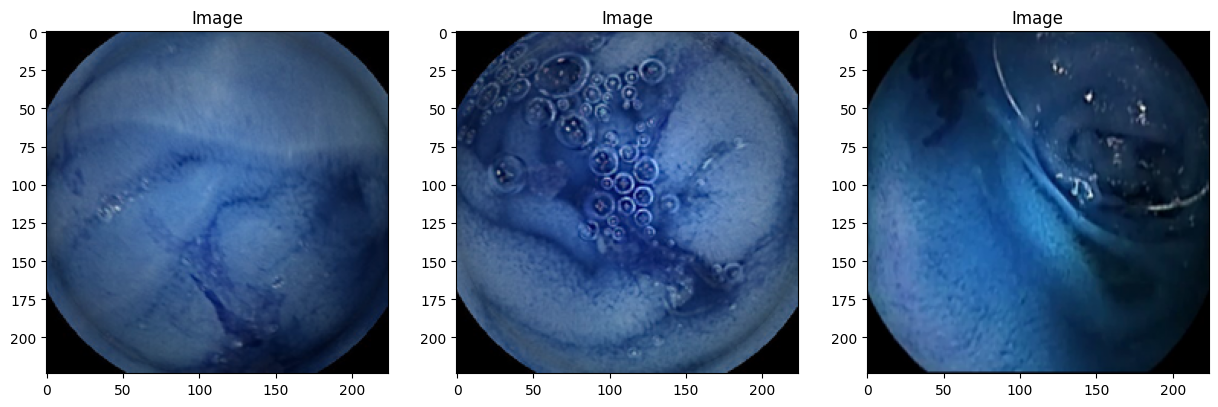

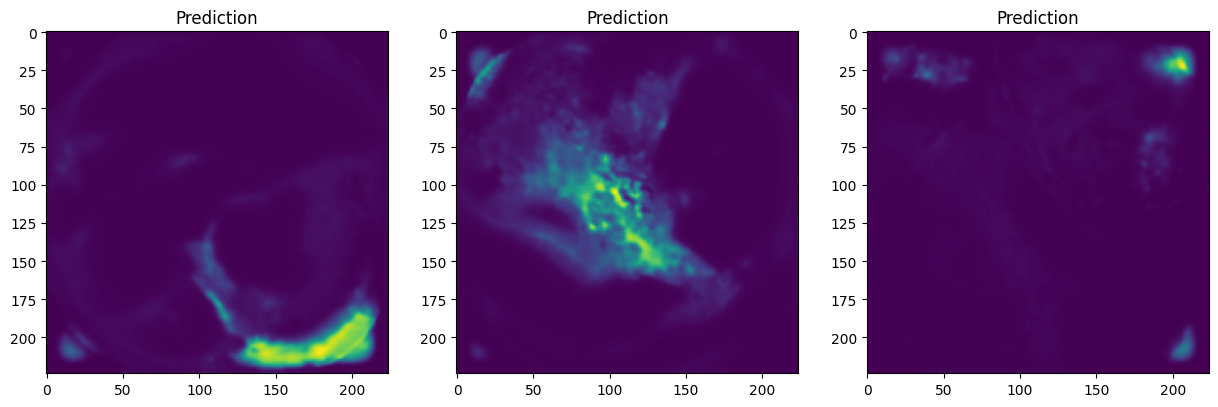

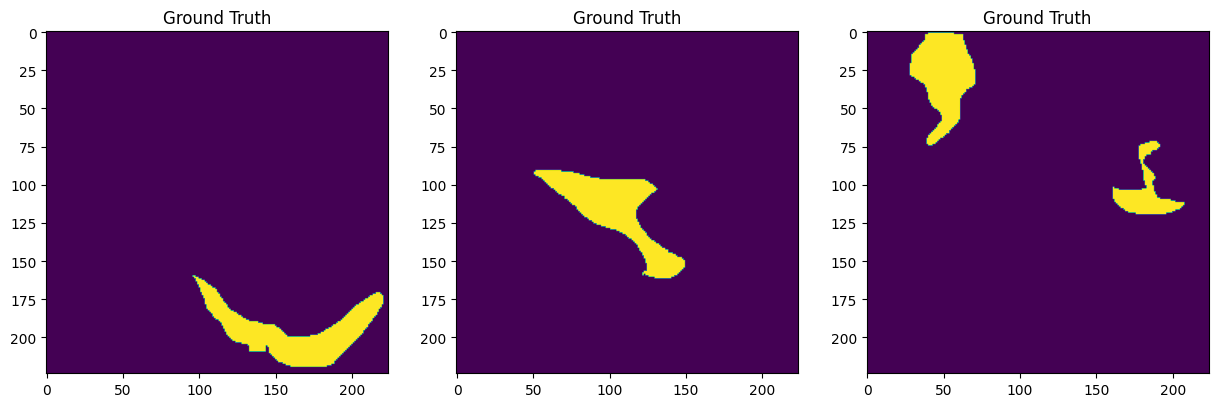

In [28]:
i = 5

# plt.imshow(pred[i])
# plt.show()

# plt.imshow(init_y[i])
# plt.show()

# Plot 3 images in matplotlib side by side horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate([axs[0], axs[1], axs[2]]):
    ax.imshow(init_x[i+1])
    ax.set_title("Image")
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate([axs[0], axs[1], axs[2]]):
    ax.imshow(pred[i+1])
    ax.set_title("Prediction")
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate([axs[0], axs[1], axs[2]]):
    ax.imshow(init_y[i+1])
    ax.set_title("Ground Truth")
plt.show()

In [37]:
# Find the maximum value in an array
def max_in_array(my_list):
    return np.amax(my_list)

max_in_array(init_x[0])

1.0